In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve


In [3]:
data = pd.read_csv('prueba5.csv', encoding='latin-1')
data = data.dropna()
data.head()

,data,target
0,Go until jurong point crazy.. Available only ...,ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,Nah I don t think he goes to usf he lives aro...,ham


In [4]:
data = data.rename(columns={"data" : "text", "target":"label"})

In [5]:
data['label'].value_counts()

ham     848
spam    152
Name: label, dtype: int64

In [6]:
# Import nltk packages and Punkt Tokenizer Models
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
ham_words = ''
spam_words = ''

In [8]:
# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [9]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

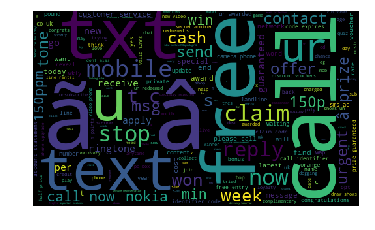

In [10]:
# plt.figure( figsize=(10,8), facecolor='w')
plt.figure( figsize=(10,3), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

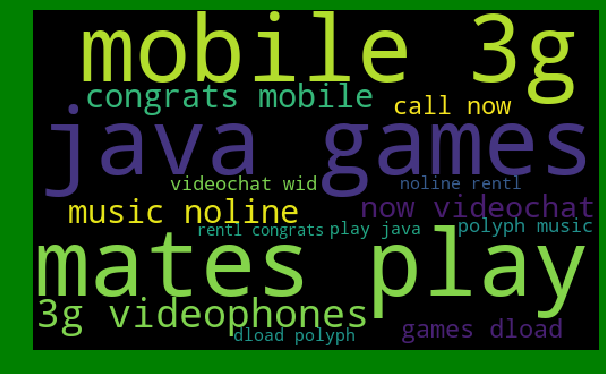

In [11]:
#Creating Ham wordcloud
plt.figure( figsize=(10,5), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [12]:
data = data.replace(['ham','spam'],[0, 1])
data.head(10)

,text,label
0,Go until jurong point crazy.. Available only ...,0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,Nah I don t think he goes to usf he lives aro...,0
5,FreeMsg Hey there darling it s been 3 week s n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


In [13]:
#posible cambio a int32
import nltk
nltk.download('stopwords')

#remove the punctuations and stopwords
import string
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label
0,Go jurong point crazy Available bugis n great ...,0
1,Ok lar Joking wif u oni,0
2,Free entry 2 wkly comp win FA Cup final tkts 2...,1
3,U dun say early hor U c already say,0
4,Nah think goes usf lives around though,0


In [14]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

In [15]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  3864


In [16]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['u', '2', 'call', 'U', 'lt', 'get', '4', 'ur', 'know', 'gt', 'like', 'go', 'Call', 'text', 'got', 'time', 'day', 'need', 'come', 'want', 'send', 'still', 'week', 'love', 'going', 'Sorry', 'see', 'think', 'ok', 'reply', 'home', 'already', 'one', 'free', 'lor', 'back', 'good', 'great', 'txt', 'way', 'Ok', 'take', 'much', '1', 'Ã\x8c', 'give', 'FREE', 'claim', 'today', 'msg', 'miss', 'later', 'say', 'night', 'sure', 'dont', 'said', 'sent', 'phone', 'mobile']


In [17]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [18]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [19]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape


(1000, 3864)

In [20]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape


(1000, 3317)

In [21]:
#features = word_vectors
features = vectors

In [22]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [23]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [24]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [25]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [26]:
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [27]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [28]:
pred_scores_word_vectors

[('LR', [0.9]),
 ('DT', [0.96]),
 ('KN', [0.8933333333333333]),
 ('RF', [0.9533333333333334]),
 ('NB', [0.98]),
 ('SVC', [0.9533333333333334])]

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[122   0]
 [  7  21]]
